# COMP4318/COMP5318 Assignment 2

In this template, we have provided data loading code and section headings to help structure your notebook. Please refer to the assignment specification pdf to guide the content of your notebook and report.




# Setup

In [22]:
import numpy as np
import pandas as pd
# import seaborn as sns
import sklearn
import pickle
import time
import matplotlib.pyplot as plt


from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision.transforms as T
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


import numpy as np
import pandas as pd
from itertools import product
import ast
import re

from itertools import product



# Data loading, exploration, and preprocessing

## Data loading

In [23]:
# Load data files assuming Assignment2Data folder 
# is present in the same directory as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

In [24]:
print('dataset: X_train.shape = {}, Y_train.shape = {}'.format(X_train.shape, y_train.shape))
print('dataset: X_test.shape = {}, Y_test.shape = {}'.format(X_test.shape, y_test.shape))


dataset: X_train.shape = (13673, 28, 28, 3), Y_train.shape = (13673,)
dataset: X_test.shape = (3419, 28, 28, 3), Y_test.shape = (3419,)


## Data exploration

In [25]:
X_train.dtype
y_train.dtype

dtype('uint8')

In [26]:
unique_train, unique_indices = np.unique(y_train, return_index=True)
sorted_num = y_train[unique_indices]
num_classes_train = len(unique_train)
print("Number of classes: ", num_classes_train)
print(sorted_num)

Number of classes:  8
[0 1 2 3 4 5 6 7]


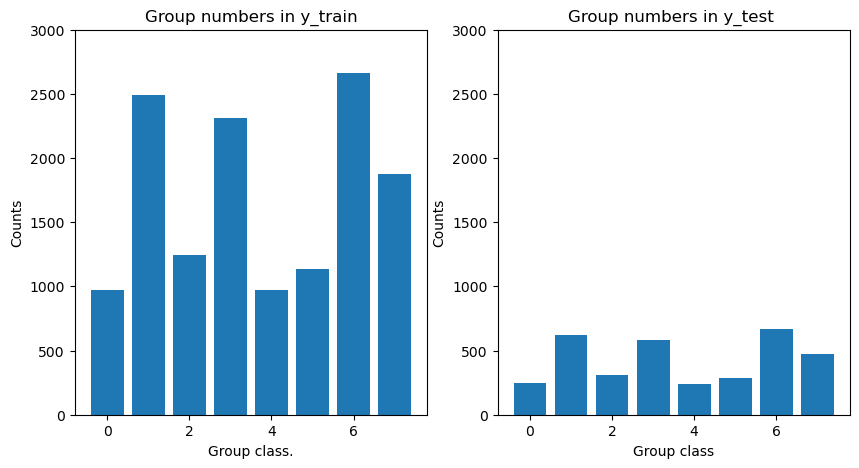

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
unique_train_1, counts_1 = np.unique(y_train, return_counts=True)
unique_train_2, counts_2 = np.unique(y_test, return_counts=True)

plt.subplot(1,2,1)
plt.bar(unique_train_1, counts_1)
plt.xlabel('Group class.')
plt.ylabel('Counts')
plt.ylim(bottom = 0, top = 3000)
plt.title('Group numbers in y_train')

plt.subplot(1,2,2)
plt.bar(unique_train_2, counts_2)
plt.xlabel('Group class')
plt.ylabel('Counts')
plt.title('Group numbers in y_test ')
plt.ylim(bottom = 0, top = 3000)
plt.show()


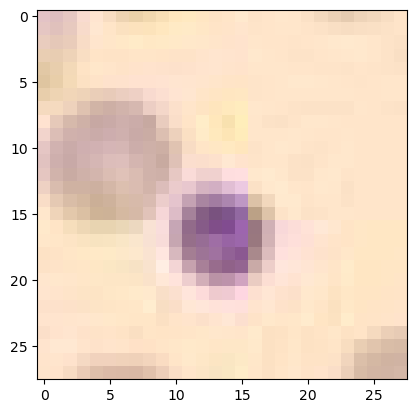

In [28]:
# We can now visualise some images to better understand the problem our model will aim to solve
plt.imshow(X_train[0], cmap="binary")
plt.show()

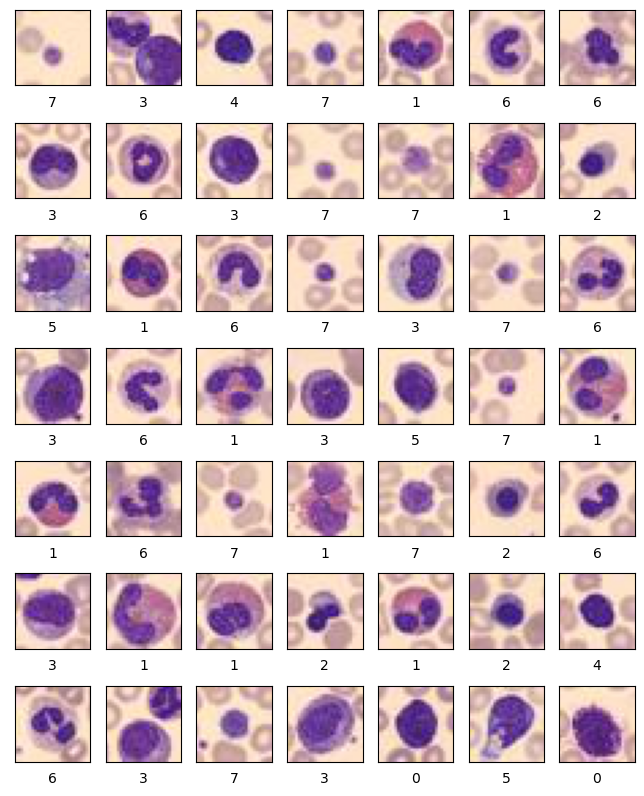

In [29]:
plt.figure(figsize=(8,10))
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(y_train[i])
plt.show()

## Preprocessing

In [30]:
class Timer:
    def __init__(self):
        self.start_time = None
        self.times = []

    def start(self):
        self.start_time = time.time()

    def stop(self):
        elapsed_time = time.time() - self.start_time
        self.times.append(elapsed_time)
        return elapsed_time
    

def draw(data):
    # Define axis labels
    xLabel = ['0','1','2','3','4','5','6','7']
    yLabel = ['0','1','2','3','4','5','6','7']

    # Create a new figure
    fig = plt.figure()

    # Add a subplot
    ax = fig.add_subplot(111)

    # Set y-axis ticks and labels
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)

    # Set x-axis ticks and labels
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)

    # Create the heatmap
    im = ax.imshow(data, cmap=plt.cm.hot_r)

    # Add a color bar
    plt.colorbar(im)

    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Show the plot
    plt.show()



## Examples of preprocessed data
Please print/display some examples of your preprocessed data here. 

In [31]:
print("X_train reshaped and normalized", X_test[0])
print("y_train with catagorized", y_test[0])

X_train reshaped and normalized [[[201 164 156]
  [198 162 164]
  [197 158 176]
  ...
  [255 227 203]
  [254 228 205]
  [253 228 206]]

 [[185 151 141]
  [184 148 148]
  [176 140 154]
  ...
  [255 227 203]
  [254 228 205]
  [253 229 205]]

 [[183 149 137]
  [184 150 148]
  [175 139 151]
  ...
  [254 228 201]
  [253 229 203]
  [253 229 205]]

 ...

 [[193 163 165]
  [202 172 174]
  [218 188 190]
  ...
  [188 157 152]
  [186 155 152]
  [185 154 152]]

 [[187 157 159]
  [190 160 162]
  [203 172 177]
  ...
  [183 151 152]
  [180 148 151]
  [178 146 149]]

 [[192 160 165]
  [186 154 159]
  [189 156 163]
  ...
  [187 155 160]
  [183 151 156]
  [181 148 155]]]
y_train with catagorized 1


In [32]:
#data processing for svm and rf
x_train =  np.reshape(X_train, (X_train.shape[0], -1))
x_test = np.reshape(X_test, (X_test.shape[0], -1))
scaler = MinMaxScaler() 
scaler = scaler.fit(x_train) 
X_train_norm = scaler.transform(x_train) 

scaler = scaler.fit(x_test) 
X_test_norm = scaler.transform(x_test) 

In [33]:
class Assignment2Data(data.Dataset):
    def __init__(self,  X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
        self.images = X
        
    def __len__ (self):
        return len(self.X)
    
    def __getitem__(self, index):
        self.XX = self.X[index]
        self.yy = self.y[index]
        if self.transform:
            self.XX = self.transform(self.XX)
        return self.XX, self.yy

batch_size = 256
X_train_origin = np.load('Assignment2Data/X_train.npy')
y_train_origin = np.load('Assignment2Data/y_train.npy')
X_test_origin = np.load('Assignment2Data/X_test.npy')
y_test_origin = np.load('Assignment2Data/y_test.npy')

x_train = X_train_origin.astype('float32')
y_train = y_train_origin.reshape(-1).astype('int64')
y_train = torch.tensor(y_train).to(torch.int64) 
Assignment2Data_train = Assignment2Data(x_train, y_train, transform=T.Compose([T.ToTensor()]))
train_iter = data.DataLoader(Assignment2Data_train, batch_size=batch_size, shuffle=True)

x_test = X_test_origin.astype('float32')
y_test = y_test_origin.reshape(-1).astype('int64')
y_test = torch.tensor(y_test).to(torch.int64)
Assignment2Data_test = Assignment2Data(x_test, y_test, transform=T.Compose([T.ToTensor()]))
test_iter = data.DataLoader(Assignment2Data_test, batch_size=batch_size, shuffle=False)


# Algorithm design and setup

## Model 1 - Fully Connected Neural Network

In [34]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.linear1=nn.Sequential(nn.Flatten(),nn.Linear(2352, 1024),nn.ReLU(),nn.Dropout(0.2))
        self.linear2=nn.Sequential(nn.Linear(1024, 512),nn.ReLU(),nn.Dropout(0.2))
        self.linear3=nn.Sequential(nn.Linear(512, 256),nn.ReLU(),nn.Dropout(0.2))
        self.out = nn.Linear(256, 8) 

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        output = self.out(x)
        return output

## Model 2 - Convolutional Neural Network

In [35]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16,  kernel_size=4,  stride=1,  padding=2 ),nn.ReLU(),nn.MaxPool2d(kernel_size=2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2), nn.ReLU(), nn.MaxPool2d(2))
        self.out = nn.Linear(32 * 7 * 7, 8)  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  
        output = self.out(x)
        return output

## Model 3 - Algorithm Choice 1

### Decision tree

In [36]:
rf_model=RandomForestClassifier()

## Model 4 - Algorithm Choice 2

### SVM

In [37]:
svm_model=svm.SVC()

# Hyperparameter tuning

## Model 1 - Fully Connected Neural Network

In [36]:


def train_and_test_model(fcn, LR, EPOCH, OPTIMIZER, train_iter, test_iter):
    if OPTIMIZER == 'Adam':
        optimizer = torch.optim.Adam(fcn.parameters(), lr=LR)
    elif OPTIMIZER == 'Adagrad':
        optimizer = torch.optim.Adagrad(fcn.parameters(), lr=LR)
    loss_func = nn.CrossEntropyLoss()  

    train_losses = []
    train_accuracies = []
    best_acc = 0
    for epoch in range(EPOCH):
        epoch_loss = 0.0
        total_batches = 0
        for step, (b_x, b_y) in enumerate(train_iter):  
            output = fcn(b_x)  
            loss = loss_func(output, b_y)
            epoch_loss += loss.data
            total_batches += 1
            optimizer.zero_grad() 
            loss.backward()  
            optimizer.step()
        
        average_epoch_loss = epoch_loss / total_batches
        train_losses.append(average_epoch_loss)
        
        if epoch % 5 == 0: 
            correct = 0
            total = 0
            for step_test, (test_x, test_y) in enumerate(test_iter):
                test_output = fcn(test_x)
                pred_y = torch.max(test_output, 1)[1].data.squeeze()
                correct += (pred_y == test_y).sum().item()
                total += test_y.size(0)
            accuracy = correct / total
            train_accuracies.append(accuracy)
            if accuracy > best_acc:
                best_acc = accuracy
            print('Epoch:', epoch,  'Optimizer' , OPTIMIZER, '| train loss: %.4f' % average_epoch_loss, '| test accuracy: %.2f' % accuracy)
    return train_losses, train_accuracies, best_acc


param_grid = {
    'learning_rate': [0.001, 0.002],
    'epochs': [10, 20],
    'optimizer': ['Adam', 'Adagrad']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

best_accuracy = 0
best_params = None
best_model = None

timer = Timer()
timer.start()

data_to_save = []

for params in all_params:
    fcn = FCN()
    LR = params['learning_rate']
    EPOCH = params['epochs']
    OPTIMIZER = params['optimizer']
    train_losses, train_accuracies, acc = train_and_test_model(fcn, LR, EPOCH, OPTIMIZER, train_iter, test_iter)
    
    data_to_save.append({
        'learning_rate': LR,
        'epochs': EPOCH,
        'optimizer': OPTIMIZER,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies
    })
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_params = params
        best_model = fcn

if best_model is not None:
    torch.save(best_model, "best_fcn_model")

timer.stop()

# Save data to a CSV file
df = pd.DataFrame(data_to_save)
df.to_csv('training_data.csv', index=False)

print(f'Best accuracy: {best_accuracy} with parameters: {best_params}')
print(f'Training Time: {timer.times[0]:.3f} s')


Epoch: 0 Optimizer Adam | train loss: 13.4175 | test accuracy: 0.29
Epoch: 5 Optimizer Adam | train loss: 1.0163 | test accuracy: 0.58
Epoch: 0 Optimizer Adagrad | train loss: 10.8298 | test accuracy: 0.34
Epoch: 5 Optimizer Adagrad | train loss: 1.1410 | test accuracy: 0.56
Epoch: 0 Optimizer Adam | train loss: 10.6581 | test accuracy: 0.18
Epoch: 5 Optimizer Adam | train loss: 1.0486 | test accuracy: 0.60
Epoch: 10 Optimizer Adam | train loss: 0.9810 | test accuracy: 0.64
Epoch: 15 Optimizer Adam | train loss: 0.9603 | test accuracy: 0.60
Epoch: 0 Optimizer Adagrad | train loss: 8.6232 | test accuracy: 0.35
Epoch: 5 Optimizer Adagrad | train loss: 1.1238 | test accuracy: 0.56
Epoch: 10 Optimizer Adagrad | train loss: 0.9414 | test accuracy: 0.59
Epoch: 15 Optimizer Adagrad | train loss: 0.8485 | test accuracy: 0.69
Epoch: 0 Optimizer Adam | train loss: 21.6750 | test accuracy: 0.41
Epoch: 5 Optimizer Adam | train loss: 1.3186 | test accuracy: 0.50
Epoch: 0 Optimizer Adagrad | train l

In [19]:

def plot_from_csv(file_name):
    df = pd.read_csv(file_name)
    
    max_epochs = df['epochs'].max()
    
    plt.figure(figsize=(15, 5))
    
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    
    for index, row in df.iterrows():
        train_losses_str = row['train_losses']
        train_losses_values = re.findall(r'tensor\(([\d\.]+)\)', train_losses_str)
        train_losses = [float(value) for value in train_losses_values]
        
        # Convert accuracies
        train_accuracies = ast.literal_eval(row['train_accuracies'])
        
        label = f"LR={row['learning_rate']}, Epochs={row['epochs']}, Optimizer={row['optimizer']}"
        x_values = list(range(0, row['epochs'], row['epochs'] // len(train_losses)))
        x_values = x_values[:len(train_losses)] 

        ax1.plot(x_values, train_losses, label=label)

        ax1.set_title('Loss over epochs')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_xlim(0, max_epochs)

        x_values = [i * 5 for i in range(len(train_accuracies))]
        ax2.plot(x_values, train_accuracies, label=label)
        ax2.set_title('Accuracy over epochs')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlim(0, max_epochs)
    ax1.set_xlim(0, 25)
    ax1.set_xticks([0, 12.5, 25])
    ax2.set_xlim(0, 25)
    ax2.set_xticks([0, 12.5, 25])
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()



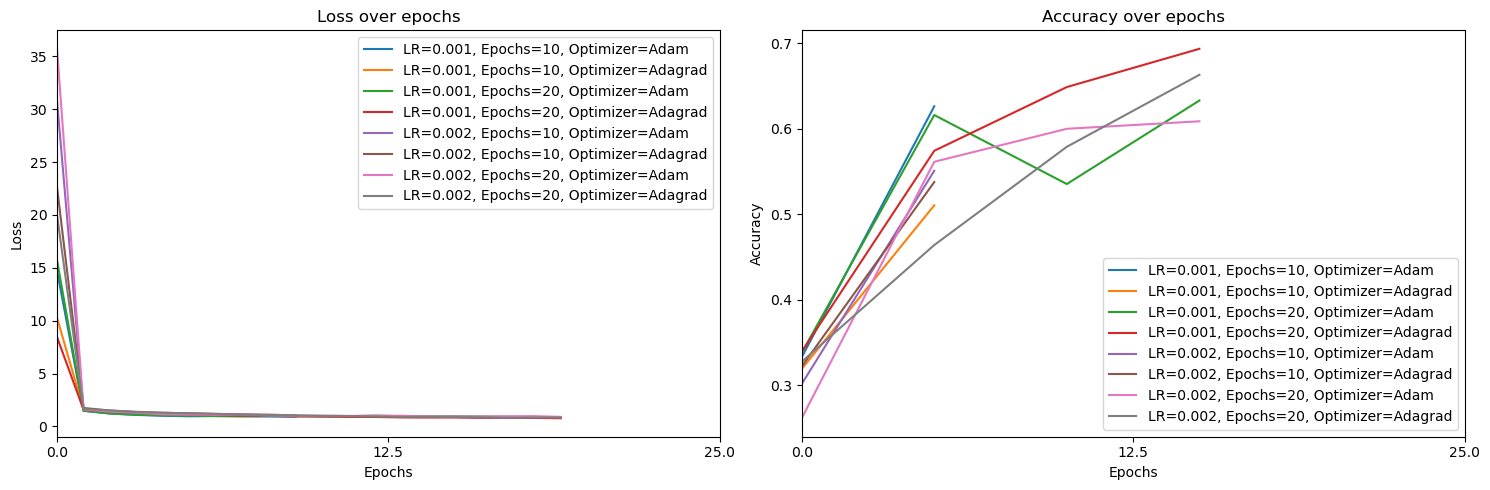

In [19]:
plot_from_csv('training_data.csv')


## Model 2 - Convolutional Neural Network

In [20]:
print("Shape of training data:", X_train_origin.shape)
print("Shape of testing data:", X_test_origin.shape)


Shape of training data: (13673, 28, 28, 3)
Shape of testing data: (3419, 28, 28, 3)


In [38]:
def train_and_test_cnn(cnn, LR, EPOCH, OPTIMIZER, train_iter, test_iter):
    if OPTIMIZER == 'Adam':
        optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
    elif OPTIMIZER == 'Adagrad':
        optimizer = torch.optim.Adagrad(cnn.parameters(), lr=LR)
    loss_func = nn.CrossEntropyLoss()
    train_losses = []
    best_acc = 0  # Initialize the best_acc variable
    for epoch in range(EPOCH):
        for step, (b_x, b_y) in enumerate(train_iter):
            output = cnn(b_x)
            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Calculate training accuracy
        with torch.no_grad():
            correct = 0
            total = 0
            for b_x, b_y in train_iter:
                output = cnn(b_x)
                _, predicted = torch.max(output.data, 1)
                total += b_y.size(0)
                correct += (predicted == b_y).sum().item()
            train_accuracy = correct / total

        # Calculate test accuracy
        with torch.no_grad():
            correct = 0
            total = 0
            for test_x, test_y in test_iter:
                test_output = cnn(test_x)
                _, predicted = torch.max(test_output.data, 1)
                total += test_y.size(0)
                correct += (predicted == test_y).sum().item()
            test_accuracy = correct / total

            if test_accuracy > best_acc:
                best_acc = test_accuracy  # Update best_acc only if the current accuracy is the best

            train_losses.append(loss.item())  # Append loss.item() to the train_losses list

            print(f'Epoch: {epoch} | Train Loss: {loss.item():.4f} | Test Accuracy: {test_accuracy:.2f}')

    return train_losses, best_acc  # Return train_losses and best_acc

param_grid = {
    'learning_rate': [0.0001, 0.0002],
    'epochs': [10, 20],
    'optimizer': ['Adam', 'Adagrad']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

best_accuracy = 0
best_params = None
best_model = None
data_to_save = []

timer = Timer()
timer.start()

for params in all_params:
    cnn = CNN()
    LR = params['learning_rate']
    EPOCH = params['epochs']
    OPTIMIZER = params['optimizer']

    train_losses, acc = train_and_test_cnn(cnn, LR, EPOCH, OPTIMIZER, train_iter, test_iter)

    data_to_save.append({
        'learning_rate': LR,
        'epochs': EPOCH,
        'optimizer': OPTIMIZER,
        'train_losses': train_losses
    })

    if acc > best_accuracy:
        best_accuracy = acc
        best_params = params
        best_model = cnn

# Save the best model
if best_model is not None:
    torch.save(best_model, "best_cnn_model")

timer.stop()

# Save data to a CSV file
df = pd.DataFrame(data_to_save)
df.to_csv('cnn_training_data.csv', index=False)

print(f'Best accuracy: {best_accuracy} with parameters: {best_params}')

Epoch: 0 | Train Loss: 3.5816 | Test Accuracy: 0.38
Epoch: 1 | Train Loss: 1.4897 | Test Accuracy: 0.51
Epoch: 2 | Train Loss: 1.9734 | Test Accuracy: 0.57
Epoch: 3 | Train Loss: 1.0606 | Test Accuracy: 0.63
Epoch: 4 | Train Loss: 1.1679 | Test Accuracy: 0.66
Epoch: 5 | Train Loss: 1.1121 | Test Accuracy: 0.70
Epoch: 6 | Train Loss: 0.9673 | Test Accuracy: 0.73
Epoch: 7 | Train Loss: 0.6030 | Test Accuracy: 0.75
Epoch: 8 | Train Loss: 0.8559 | Test Accuracy: 0.76
Epoch: 9 | Train Loss: 0.8016 | Test Accuracy: 0.77
Epoch: 0 | Train Loss: 4.0048 | Test Accuracy: 0.20
Epoch: 1 | Train Loss: 3.2382 | Test Accuracy: 0.27
Epoch: 2 | Train Loss: 2.9630 | Test Accuracy: 0.33
Epoch: 3 | Train Loss: 2.7123 | Test Accuracy: 0.37
Epoch: 4 | Train Loss: 2.2585 | Test Accuracy: 0.40
Epoch: 5 | Train Loss: 1.9794 | Test Accuracy: 0.41
Epoch: 6 | Train Loss: 1.5416 | Test Accuracy: 0.42
Epoch: 7 | Train Loss: 1.6055 | Test Accuracy: 0.45
Epoch: 8 | Train Loss: 1.8883 | Test Accuracy: 0.47
Epoch: 9 | T

In [39]:
print(f'Training Time: {timer.times[0]:.3f} s')

Training Time: 1178.439 s


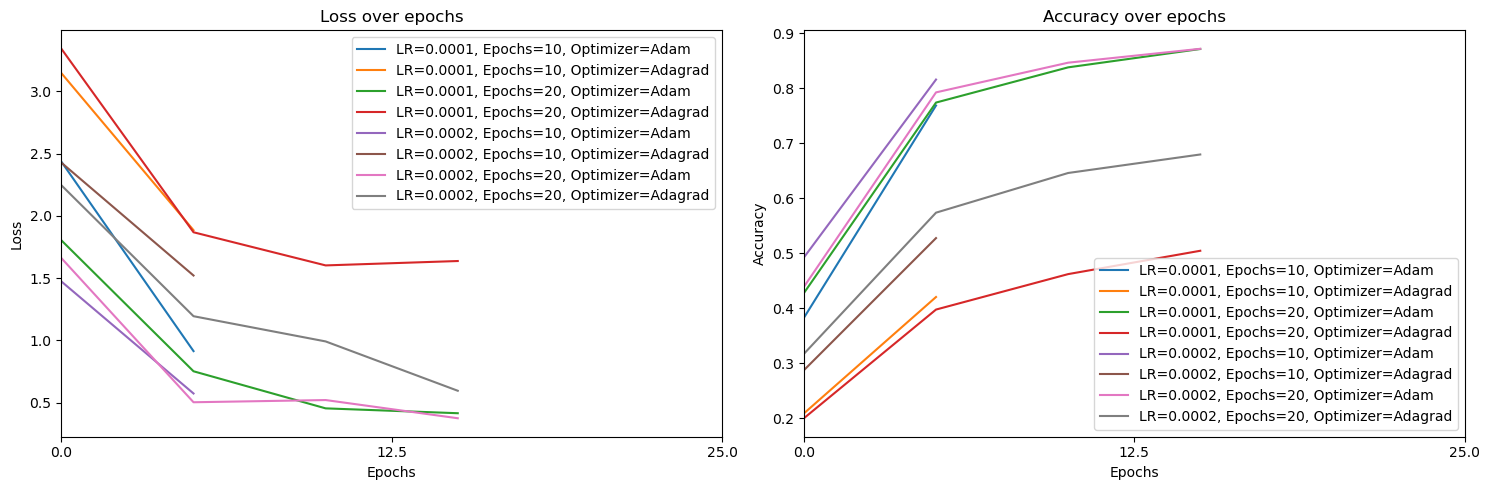

In [20]:
plot_from_csv('cnn_training_data.csv')

## Model 3 - Algorithm Choice 1

### Random forest

In [38]:
total_timer=Timer()
total_timer.start()
for n_estimators in range(50,200,25):
    for max_features in range(2,10,2):
        for criterion in ["gini","entropy"]:
            rf_model=RandomForestClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features,criterion=criterion)
            rf_model.fit(X_train_norm, y_train)
            y_pred = rf_model.predict(X_test_norm)
            acc = accuracy_score(y_test, y_pred)
            print(n_estimators,max_features,criterion,f"Accuracy:{acc * 100:.3f}%")

total_timer.stop()        
print(f'Total Time:{total_timer.times[0]:.3f} s')            
            


50 2 gini Accuracy:76.046%
50 2 entropy Accuracy:75.870%
50 4 gini Accuracy:79.789%
50 4 entropy Accuracy:78.356%
50 6 gini Accuracy:79.819%
50 6 entropy Accuracy:79.000%
50 8 gini Accuracy:80.842%
50 8 entropy Accuracy:80.491%
75 2 gini Accuracy:76.952%
75 2 entropy Accuracy:76.748%
75 4 gini Accuracy:80.199%
75 4 entropy Accuracy:79.760%
75 6 gini Accuracy:80.521%
75 6 entropy Accuracy:80.228%
75 8 gini Accuracy:81.164%
75 8 entropy Accuracy:80.872%
100 2 gini Accuracy:76.982%
100 2 entropy Accuracy:77.420%
100 4 gini Accuracy:80.784%
100 4 entropy Accuracy:80.199%
100 6 gini Accuracy:81.047%
100 6 entropy Accuracy:80.491%
100 8 gini Accuracy:81.398%
100 8 entropy Accuracy:81.398%
125 2 gini Accuracy:77.391%
125 2 entropy Accuracy:77.625%
125 4 gini Accuracy:81.018%
125 4 entropy Accuracy:80.316%
125 6 gini Accuracy:81.457%
125 6 entropy Accuracy:80.608%
125 8 gini Accuracy:81.632%
125 8 entropy Accuracy:81.661%
150 2 gini Accuracy:78.005%
150 2 entropy Accuracy:77.976%
150 4 gini Ac

## Model 4 - Algorithm Choice 2

### SVM

In [39]:
#grid_search
total_timer=Timer()
total_timer.start()
for c in [0.1,1,5]:
    for kernel in ['linear', 'poly']:
        for gamma in ['scale', 'auto']:
            svc_model=svm.SVC(C=c,kernel=kernel,gamma=gamma,decision_function_shape="ovo")
            svc_model.fit(X_train_norm, y_train)
            y_pred = svc_model.predict(X_test_norm)
            acc = accuracy_score(y_test, y_pred)
            print(c,kernel,gamma,f"Accuracy:{acc * 100:.3f}%")

total_timer.stop()        
print(f'Total Time:{total_timer.times[0]:.3f} s')            
            

0.1 linear scale Accuracy:81.427%
0.1 linear auto Accuracy:81.427%
0.1 poly scale Accuracy:84.820%
0.1 poly auto Accuracy:49.371%
1 linear scale Accuracy:80.140%
1 linear auto Accuracy:80.140%
1 poly scale Accuracy:84.352%
1 poly auto Accuracy:67.681%
5 linear scale Accuracy:77.596%
5 linear auto Accuracy:77.596%
5 poly scale Accuracy:84.294%
5 poly auto Accuracy:74.963%
Total Time:1043.113 s


# Final Models

## Model 1 - Fully Connected Neural Network

| Test accuracy: 0.69 Test Time: 0.527 s
              precision    recall  f1-score   support

           0       0.55      0.36      0.43       244
           1       0.73      0.87      0.79       623
           2       0.66      0.65      0.66       310
           3       0.52      0.55      0.54       579
           4       0.85      0.51      0.64       243
           5       0.49      0.50      0.50       284
           6       0.81      0.76      0.79       666
           7       0.86      0.99      0.92       470

    accuracy                           0.70      3419
   macro avg       0.69      0.65      0.66      3419
weighted avg       0.70      0.70      0.69      3419



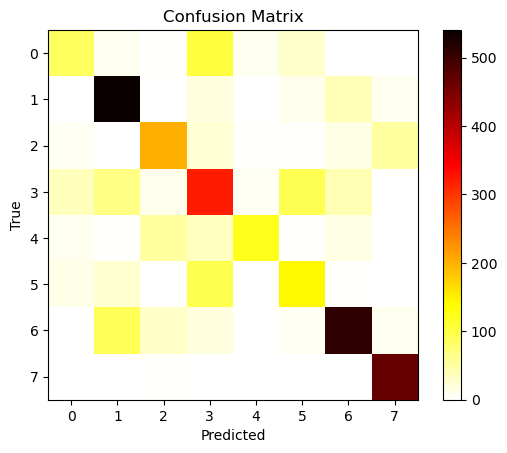

In [37]:
fcn_model = FCN() 
fcn_model = torch.load("best_fcn_model")
test_timer=Timer()
test_timer.start()


correct = 0
total = 0

for step_test, (test_x, test_y) in enumerate(test_iter):
    test_output = fcn_model(test_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    correct += (pred_y == test_y).sum().item()
    total += test_y.size(0)

accuracy = correct / total
test_timer.stop()
print(f'| Test accuracy: {accuracy:.2f} Test Time: {test_timer.times[0]:.3f} s')

pred_y_list = []
test_y_list = []

for step_test, (test_x, test_y) in enumerate(test_iter):
    test_output = fcn_model(test_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    pred_y_list += pred_y.numpy().tolist()
    test_y_list += test_y.numpy().tolist()

y_pred = np.array(pred_y_list)
y_true = np.array(test_y_list)

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
draw(cm)





## Model 2 - Convolutional Neural Network

| Test accuracy: 0.86 Test Time: 1.650 s
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       244
           1       0.98      0.90      0.94       623
           2       0.85      0.90      0.87       310
           3       0.75      0.68      0.71       579
           4       0.80      0.79      0.80       243
           5       0.72      0.73      0.73       284
           6       0.91      0.94      0.93       666
           7       1.00      0.99      0.99       470

    accuracy                           0.86      3419
   macro avg       0.83      0.85      0.84      3419
weighted avg       0.86      0.86      0.86      3419



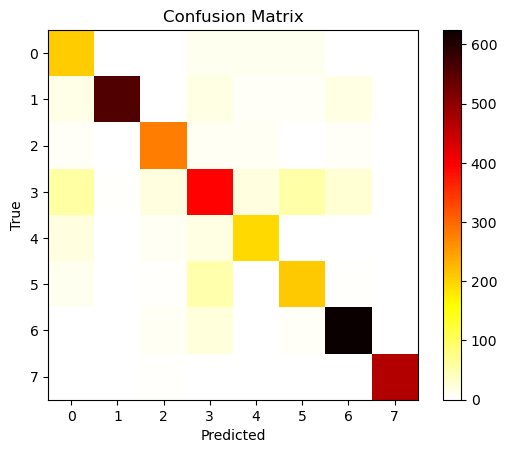

In [34]:
cnn_model = CNN() 
cnn_model = torch.load("best_cnn_model")
test_timer=Timer()
test_timer.start()

correct = 0
total = 0

for step_test, (test_x, test_y) in enumerate(test_iter):
    test_output = cnn_model(test_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    correct += (pred_y == test_y).sum().item()
    total += test_y.size(0)

accuracy = correct / total
test_timer.stop()
print(f'| Test accuracy: {accuracy:.2f} Test Time: {test_timer.times[0]:.3f} s')

pred_y_list = []
test_y_list = []

for step_test, (test_x, test_y) in enumerate(test_iter):
    test_output = cnn_model(test_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    pred_y_list += pred_y.numpy().tolist()
    test_y_list += test_y.numpy().tolist()

y_pred = np.array(pred_y_list)
y_true = np.array(test_y_list)

print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
draw(cm)

## Model 3 - Algorithm Choice 1

### Random forest

| Test accuracy: 0.82 Total Time: 0.166 s
              precision    recall  f1-score   support

           0       0.72      0.52      0.60       244
           1       0.91      0.93      0.92       623
           2       0.87      0.82      0.85       310
           3       0.60      0.83      0.69       579
           4       0.82      0.76      0.79       243
           5       0.92      0.34      0.50       284
           6       0.87      0.93      0.90       666
           7       1.00      0.99      0.99       470

    accuracy                           0.82      3419
   macro avg       0.84      0.76      0.78      3419
weighted avg       0.84      0.82      0.81      3419



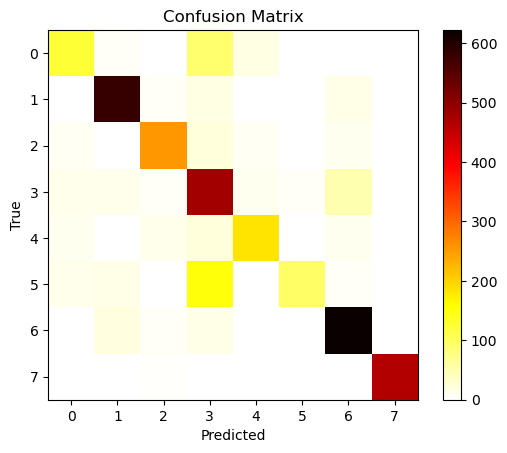

In [40]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=175, max_features=8, criterion="gini")

rf_model.fit(X_train_norm, y_train)

test_timer = Timer()
test_timer.start()

y_pred = rf_model.predict(X_test_norm)

acc = accuracy_score(y_test, y_pred)

test_timer.stop()

print(f'| Test accuracy: {acc:.2f} Total Time: {test_timer.times[0]:.3f} s')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
draw(cm)

## Model 4 - Algorithm Choice 2

### SVM

| Test accuracy: 0.85 Total Time: 8.474 s
              precision    recall  f1-score   support

           0       0.75      0.70      0.73       244
           1       0.98      0.92      0.95       623
           2       0.79      0.94      0.86       310
           3       0.63      0.86      0.73       579
           4       0.88      0.75      0.81       243
           5       0.91      0.45      0.60       284
           6       0.94      0.88      0.91       666
           7       1.00      0.99      0.99       470

    accuracy                           0.85      3419
   macro avg       0.86      0.81      0.82      3419
weighted avg       0.87      0.85      0.85      3419

[[172   0   2  63   7   0   0   0]
 [ 12 576   0  17   2   1  15   0]
 [  1   0 290   5   5   3   5   1]
 [ 25   2  23 500  10   5  14   0]
 [  4   0  27  27 182   1   2   0]
 [ 15   1   2 136   1 127   2   0]
 [  0   6  20  51   0   2 587   0]
 [  0   0   3   0   0   0   1 466]]


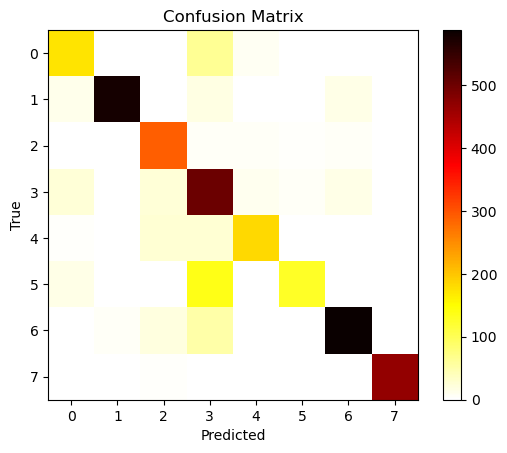

In [41]:
svc_model = svm.SVC(C=0.1, kernel="poly", gamma='scale', decision_function_shape="ovo")

svc_model.fit(X_train_norm, y_train)

test_timer = Timer()
test_timer.start()

y_pred = svc_model.predict(X_test_norm)

acc = accuracy_score(y_test, y_pred)

test_timer.stop()
print(f'| Test accuracy: {acc:.2f} Total Time: {test_timer.times[0]:.3f} s')

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
draw(cm)